# **<font color=white> 13.Gradient Boosting Machine Code 실습**

[목적]
  - Bias를 낮추기위한 Boosting 모델의 AdaBoost을 개선한 GBM 실습 및 해석

[Process]
  - Define X's & Y
  - Split Train & Valid dataset
  - Modeling
  - Model 해석

- GBM은 손실 함수의 그래디언트(경사도)를 사용하여 약한 학습기를 순차적으로 학습시킵니다.
  - Gradient Boosting의 기본 아이디어:
    - Gradient Boosting은 Boosting 계열의 앙상블 기법 중 하나입니다. Boosting은 약한 학습기(weak learners)를 순차적으로 학습시키면서, 이전 학습기의 오차를 다음 학습기가 보정하게 하는 방식입니다.

  - 손실 함수의 그래디언트 사용:
    - Gradient Boosting에서는 "그래디언트"의 개념이 중요한 역할을 합니다. 여기서 그래디언트는 주어진 손실 함수(loss function)에 대한 미분값, 즉 경사도를 의미합니다. 손실 함수는 모델의 예측값과 실제 값의 차이를 측정하는 함수로, 이 차이를 최소화하는 것이 목표입니다.

  - 첫 번째 학습기는 단순히 데이터를 학습합니다.
    - 두 번째 학습기부터는 이전 학습기의 예측에서의 "오차"를 대상으로 학습을 진행합니다. 이 때의 오차는 손실 함수의 그래디언트, 즉 손실 함수가 최소가 되는 방향으로의 변화율로 표현됩니다.
    - 이 과정을 반복하면서, 각 학습기는 이전 학습기의 오차를 줄이는 방향으로 학습을 진행합니다.
  - 좀 더 구체적으로 설명:

    - 초기 예측값을 설정합니다. (초기값은 주로 평균값, 중간값 등으로 설정할 수 있습니다.)
    - 현재 모델의 예측값과 실제값 사이의 차이를 계산하여 손실 함수의 값(loss)을 구합니다.
    - 손실 함수를 그래디언트(미분)하여, 각 데이터 포인트에서의 그래디언트 값을 얻습니다. 이 값은 오차의 방향과 크기를 나타냅니다.
    - 그래디언트 값들을 "새로운 레이블"처럼 사용하여 약한 학습기(예: 의사결정 트리)를 학습시킵니다.
    - 학습된 약한 학습기를 사용하여 예측값을 업데이트하게 됩니다.
    - 위 과정을 n_estimators로 지정한 횟수만큼 반복합니다.
  - 즉, Gradient Boosting은 각 단계에서 이전 단계의 오차를 그래디언트 방향으로 보정해 나가는 방식으로 동작하며, 이를 통해 전체적인 예측 성능을 향상시킵니다.
- 각각의 트리는 이전 트리의 오차를 보정하는 방향으로 학습됩니다.
- GBM은 다양한 손실 함수를 사용할 수 있기 때문에 회귀, 분류 등 다양한 문제에 적용될 수 있습니다.

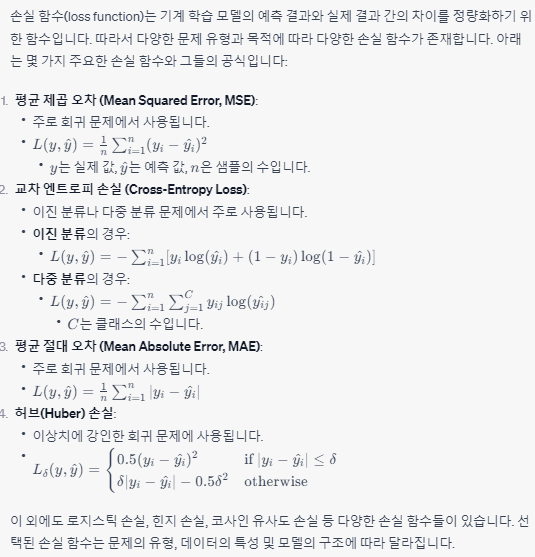

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [4]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[Gradient Boosting Machine Parameters]
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
  - n_estimators : # of Tree
  - learning_rate : learning_rate과 n_estimator와 Trade-off 관계가 있음
    - Weight applied to each classifier at each boosting iteration
  - max_features : Feature 수 sampling (Overfitting 방지)
  - subsample : Data Subsample (Overfitting 방지, Bootstrap X)
  - max_depth : Tree의 최대 깊이 제한

In [5]:
# GBM Hyperparameter
estimators = [10, 20, 50]
learning = [0.05, 0.1, 0.5]
subsam = [0.5, 0.75, 1]

# Modeling
save_est = []
save_lr = []
save_sub = []
f1_score_ = []

cnt = 0
for est in estimators:
    for lr in learning:
        for sub in subsam:
            print(">>> {} <<<".format(cnt))
            cnt += 1
            print("Number of Estimators : {}, Learning Rate : {}, Subsample : {}".format(est, lr, sub))

            model = GradientBoostingClassifier(n_estimators=est,
                                               learning_rate=lr,
                                               subsample=sub,
                                               random_state=119)
            model.fit(X.iloc[train_idx], Y.iloc[train_idx])

            # Train Acc
            y_pre_train = model.predict(X.iloc[train_idx])
            cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
            print("Train Confusion Matrix")
            print(cm_train)
            print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
            print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

            # Test Acc
            y_pre_test = model.predict(X.iloc[valid_idx])
            cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
            print("Test Confusion Matrix")
            print(cm_test)
            print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
            print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
            print("-----------------------------------------------------------------------")
            print("-----------------------------------------------------------------------")
            save_est.append(est)
            save_lr.append(lr)
            save_sub.append(sub)
            f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

>>> 0 <<<
Number of Estimators : 10, Learning Rate : 0.05, Subsample : 0.5
Train Confusion Matrix
[[240   1]
 [ 51  80]]
Train Acc : 0.8602150537634409
Train F1-Score : 0.7547169811320754
Test Confusion Matrix
[[102   8]
 [ 12  38]]
TesT Acc : 0.875
Test F1-Score : 0.7916666666666667
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 10, Learning Rate : 0.05, Subsample : 0.75
Train Confusion Matrix
[[240   1]
 [ 53  78]]
Train Acc : 0.8548387096774194
Train F1-Score : 0.7428571428571428
Test Confusion Matrix
[[105   5]
 [ 13  37]]
TesT Acc : 0.8875
Test F1-Score : 0.8043478260869565
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 10, Learning Rate : 0.05, Subsample : 1
Train Confusion Matrix
[[237   4]
 [ 40  91]]
Train Acc : 0.8817204

In [6]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest SubSampling : {}\nBest Learning Rate : {}".format(np.argmax(f1_score_),
                                                                                                                           f1_score_[np.argmax(f1_score_)],
                                                                                                                           save_est[np.argmax(f1_score_)],
                                                                                                                           save_sub[np.argmax(f1_score_)],
                                                                                                                           save_lr[np.argmax(f1_score_)]))

>>> 10 <<<
Best Test f1-score : 0.8807339449541285
Best n_estimators : 20
Best SubSampling : 0.75
Best Learning Rate : 0.05


- n_estimators:
  - n_estimators는 앙상블에 사용될 연속적인 트리의 수를 정의합니다.
  - 이 값이 클수록 더 많은 트리를 통해 모델을 학습시키므로 성능이 좋아질 수 있습니다. 하지만, 너무 큰 값은 오버피팅(과적합)의 위험을 증가시킬 수 있으며, 학습 시간이 길어집니다.
- learning_rate (or lr in the given code):
  - learning_rate는 각 트리에 대한 축소를 제어합니다. 일반적으로 0과 1 사이의 값을 가집니다.
  - 낮은 학습률 값은 각 트리의 기여를 줄여서, 보다 보수적인 학습을 만듭니다. 그 결과, 더 많은 트리가 필요할 수 있으나 오버피팅의 위험을 감소시킵니다. 반대로 높은 학습률은 각 트리의 기여를 강화시키지만, 오버피팅의 위험을 증가시킬 수 있습니다.
  - 학습률과 n_estimators는 상호 연관되어 있으므로, 하나를 변경할 때 다른 하나도 적절하게 조정할 필요가 있습니다.
- subsample (or sub in the given code):
  - subsample은 학습 데이터의 하위 집합(subsample)의 크기를 지정합니다.
  - 값이 1.0 이면, 전체 학습 데이터를 사용하여 각 트리를 학습시킵니다. 1.0보다 작은 값 (예: 0.8)은 학습 데이터의 80%를 무작위로 선택하여 각 트리를 학습하는 것을 의미합니다.
  - subsample이 1.0보다 작을 경우, 그 결과는 stochastic gradient boosting을 생성하게 되며, 이는 분산을 줄이고 모델의 훈련 속도를 높일 수 있습니다.
  - 그러나, 너무 작은 subsample 값은 모델의 성능을 저하시킬 수 있습니다.


이들 파라미터들은 모델의 성능과 학습 시간에 큰 영향을 미치므로, 주의 깊게 선택하고 최적화해야 합니다. 파라미터 튜닝을 위해 교차 검증(cross-validation)과 같은 기법들을 사용하여 최적의 값을 찾는 것이 일반적입니다.

In [7]:
best_model = GradientBoostingClassifier(n_estimators=save_est[np.argmax(f1_score_)],
                                        learning_rate=save_lr[np.argmax(f1_score_)],
                                        subsample = save_sub[np.argmax(f1_score_)],
                                        random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[233   8]
 [ 22 109]]
Train Acc : 0.9193548387096774
Train F1-Score : 0.8790322580645161
Test Confusion Matrix
[[99 11]
 [ 2 48]]
TesT Acc : 0.91875
Test F1-Score : 0.8807339449541285


In [8]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.671843    event
1   0.064817        r
2   0.060131    cd496
3   0.046942     wtkg
4   0.043351  preanti
5   0.033353    cd420
6   0.017538     cd80
7   0.015869     race
8   0.015430      age
9   0.012291      z30
10  0.008892     cd40
11  0.006452   karnof
12  0.001652     homo
13  0.001437     str2
14  0.000000   zprior
15  0.000000  symptom
16  0.000000    strat
17  0.000000   oprior
18  0.000000     hemo
19  0.000000   gender
20  0.000000    drugs
21  0.000000    cd820


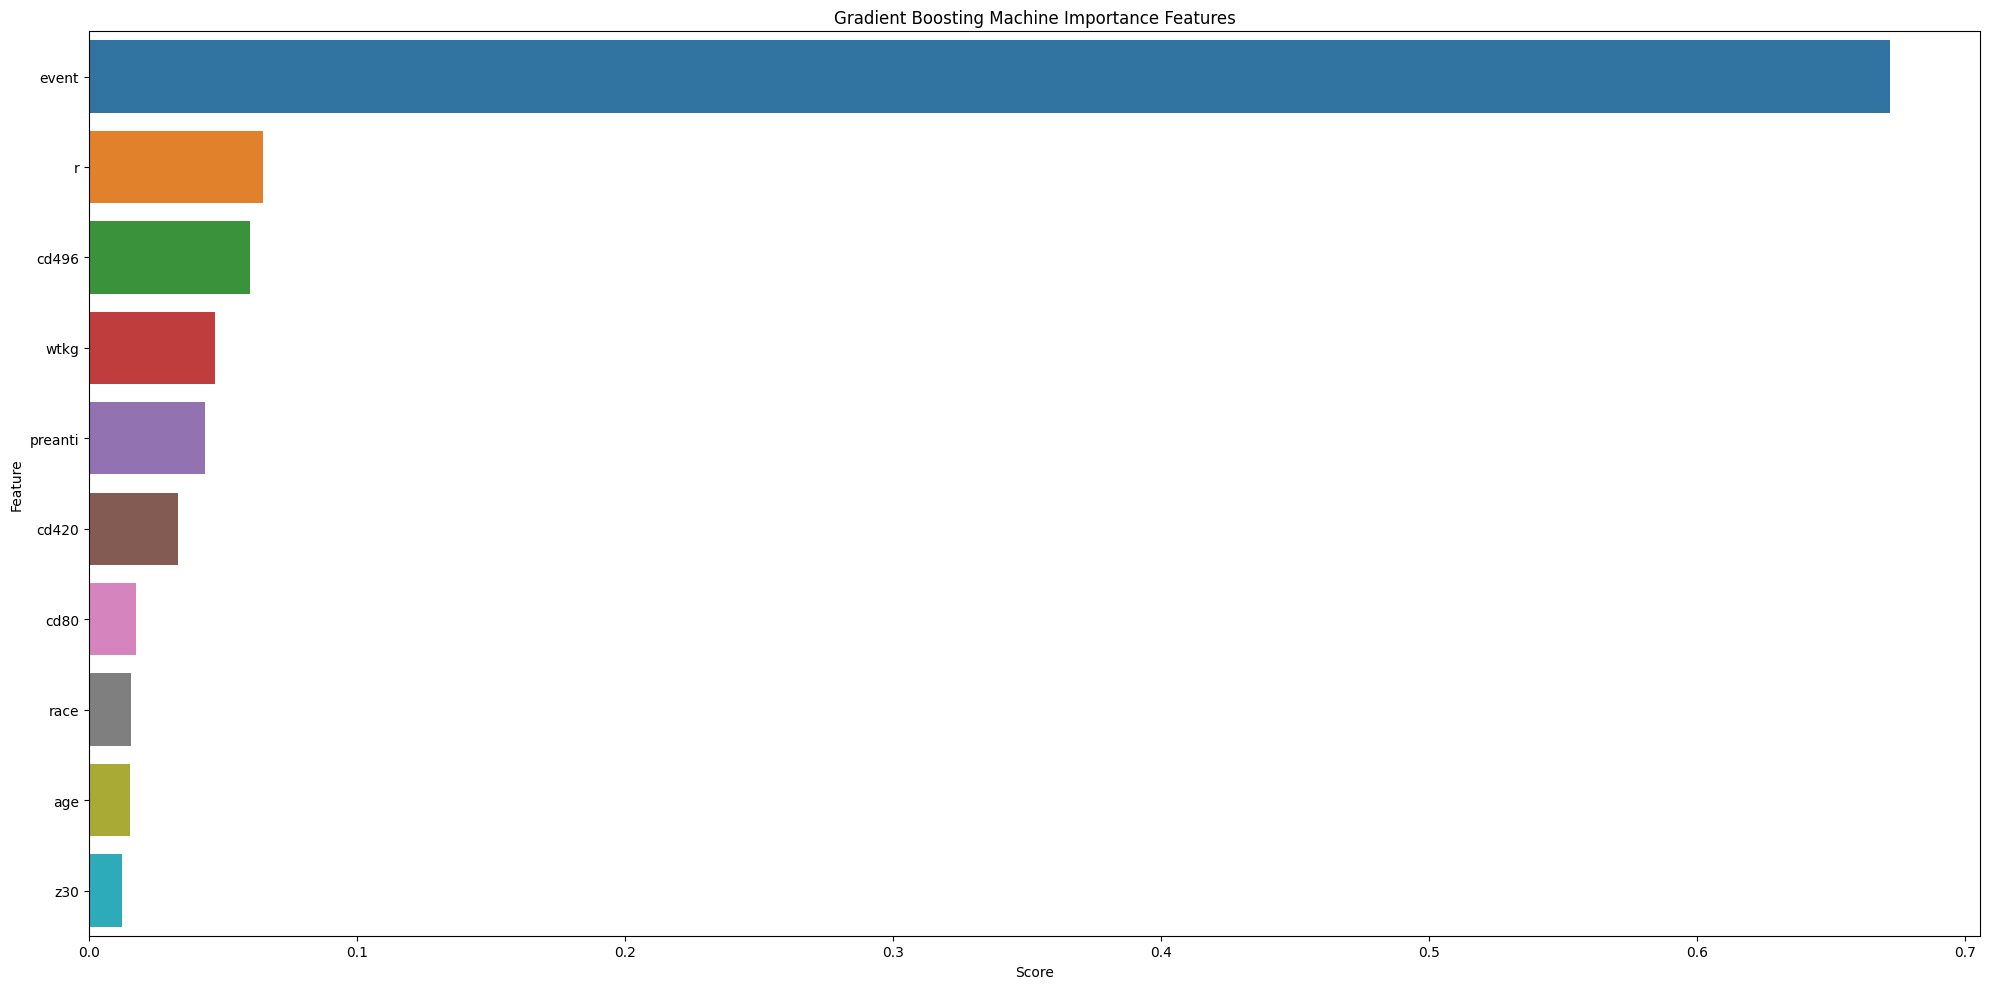

In [9]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('Gradient Boosting Machine Importance Features')
plt.tight_layout()
plt.show()

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
# Data Loading (당뇨병)
data = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t')

In [13]:
# X's & Y Split
Y = data['Y']
X = data.drop(columns=['Y'])
X = pd.get_dummies(X, columns=['SEX'])
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))

>>>> # of Train data : 309
>>>> # of valid data : 133


In [14]:
X

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,SEX_1,SEX_2
0,59,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,0,1
1,48,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,1,0
2,72,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,0,1
3,24,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,1,0
4,50,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,1,0
...,...,...,...,...,...,...,...,...,...,...,...
437,60,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,0,1
438,47,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,0,1
439,60,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,0,1
440,36,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,1,0


GradientBoostingRegressor와 GradientBoostingClassifier는 각각 회귀 문제와 분류 문제를 해결하기 위한 모델입니다. 그러므로 각각의 문제 특성에 따라 다른 평가 지표가 적합합니다.

- GradientBoostingRegressor와 mean_squared_error (MSE):
  - GradientBoostingRegressor는 연속적인 값을 예측하는 회귀 문제를 위한 것입니다.
  - MSE는 회귀 문제의 예측 성능을 측정하는 일반적인 지표 중 하나입니다. 이는 예측값과 실제 값 간의 차이를 제곱하여 평균을 구한 것입니다.
  - MSE는 예측 오차의 제곱을 통해 큰 오차에 더 큰 가중치를 부여하기 때문에, 모델이 큰 오차를 최소화하도록 유도합니다.
- GradientBoostingClassifier와 confusion_matrix:
  - GradientBoostingClassifier는 레이블을 예측하는 분류 문제를 위한 것입니다.
  - Confusion matrix는 분류 문제의 예측 성능을 이해하고 해석하기 위한 도구입니다. 이 행렬은 실제 레이블과 예측 레이블 간의 관계를 시각적으로 표현합니다.
  - Confusion matrix를 통해 True Positive, False Positive, True Negative, False Negative와 같은 여러 종류의 예측 결과를 확인할 수 있습니다. 이를 바탕으로 정밀도, 재현율, F1 점수 등의 중요한 분류 평가 지표를 계산할 수 있습니다.

왜 이러한 차이가 있는가?

회귀와 분류는 서로 다른 문제 유형입니다:

- 회귀에서는 값을 예측하는 것이 중요하므로, 실제 값과 예측 값 사이의 차이를 정량화하는 지표 (예: MSE)가 필요합니다.

- 분류에서는 레이블을 올바르게 예측하는 것이 중요하므로, 각 클래스에 대한 예측의 정확성을 확인하고 이해할 수 있는 지표 (예: confusion matrix)가 필요합니다.

물론, 분류 문제에서도 다른 평가 지표들 (예: ROC, AUC, 정밀도, 재현율 등)을 사용할 수 있으며, 회귀에서도 다른 오차 측정 지표들 (예: MAE)을 사용할 수 있습니다. 그러나 위의 설명은 이 두 모델에 대한 일반적인 평가 방법을 설명하기 위한 것입니다.

In [15]:
# GBM Hyperparameter
estimators = [70, 90, 120]
learning = [0.05, 0.1, 0.5]
subsam = [0.5, 0.75, 1]

# Modeling
save_est = []
save_lr = []
save_sub = []

cnt = 0
for est in estimators:
    for lr in learning:
        for sub in subsam:
            print(">>> {} <<<".format(cnt))
            cnt += 1
            print("Number of Estimators : {}, Learning Rate : {}, Subsample : {}".format(est, lr, sub))

            model = GradientBoostingRegressor(n_estimators=est,
                                               learning_rate=lr,
                                               subsample=sub,
                                               random_state=119)
            model.fit(X.iloc[train_idx], Y.iloc[train_idx])

            # Train Acc
            y_pre_train = model.predict(X.iloc[train_idx])
            rmse_train = np.sqrt(mean_squared_error(Y.iloc[train_idx], y_pre_train))
            print("Train RMSE : {}".format(np.sqrt(mean_squared_error(Y.iloc[train_idx], y_pre_train))))
            print("Train R2 : {}".format(r2_score(Y.iloc[train_idx], y_pre_train)))

            # Test Acc
            y_pre_test = model.predict(X.iloc[valid_idx])
            print("TesT RMSE : {}".format(np.sqrt(mean_squared_error(Y.iloc[valid_idx], y_pre_test))))
            print("Test R2 : {}".format(r2_score(Y.iloc[valid_idx], y_pre_test)))
            print("-----------------------------------------------------------------------")
            print("-----------------------------------------------------------------------")

>>> 0 <<<
Number of Estimators : 70, Learning Rate : 0.05, Subsample : 0.5
Train RMSE : 39.14524476414566
Train R2 : 0.7266482689092394
TesT RMSE : 57.075650385405474
Test R2 : 0.5038118129452638
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 70, Learning Rate : 0.05, Subsample : 0.75
Train RMSE : 38.51365298879307
Train R2 : 0.7353979352254565
TesT RMSE : 58.69109886674094
Test R2 : 0.4753264581347395
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 70, Learning Rate : 0.05, Subsample : 1
Train RMSE : 39.11886805219846
Train R2 : 0.7270165226149345
TesT RMSE : 59.67155356647381
Test R2 : 0.4576503396488516
-----------------------------------------------------------------------
-------------------------------------------------------

[ElasticNet Result]

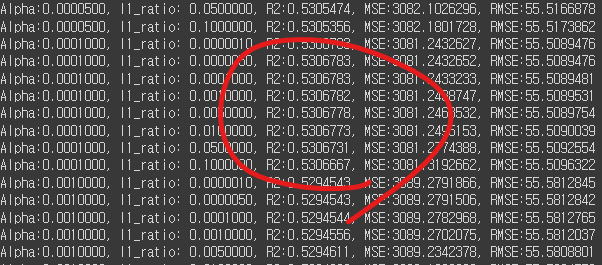